In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

Data shape: (512, 512, 216)


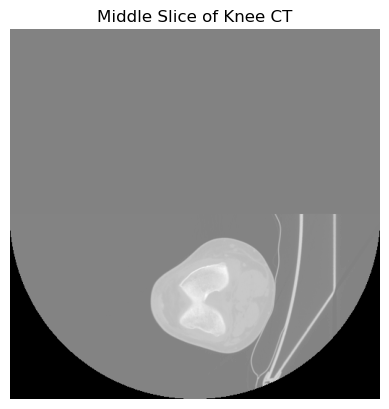

In [2]:
# Load NIfTI file
img = nib.load('../yoges/Desktop/New/3702_left_knee.nii.gz')  # Adjust path as needed
data = img.get_fdata()

print("Data shape:", data.shape)

# Show a middle slice
plt.imshow(data[:, :, data.shape[2] // 2], cmap='gray')
plt.title("Middle Slice of Knee CT")
plt.axis('off')
plt.show()

In [3]:
# Check value range and unique labels
print("Data shape:", data.shape)
print("Min/Max values:", np.min(data), np.max(data))
print("Unique values (if few):", np.unique(data)[:10]) 

Data shape: (512, 512, 216)
Min/Max values: -3024.0 1769.0
Unique values (if few): [-3024. -1024. -1023. -1022. -1021. -1020. -1019. -1018. -1017. -1016.]


In [4]:
# Create masks from labels
mask_femur = (data == 1).astype(np.uint8)
mask_tibia = (data == 2).astype(np.uint8)
mask_background = (data == 0).astype(np.uint8)

In [5]:
# Extract masked intensities
femur_volume = mask_femur * data
tibia_volume = mask_tibia * data
background_volume = mask_background * data

In [6]:
# Create binary masks for each region
mask_femur = (data == 1).astype(np.uint8)
mask_tibia = (data == 2).astype(np.uint8)
mask_background = (data == 0).astype(np.uint8)

print("Femur pixels:", np.sum(mask_femur))
print("Tibia pixels:", np.sum(mask_tibia))
print("Background pixels:", np.sum(mask_background))

Femur pixels: 7622
Tibia pixels: 7566
Background pixels: 7513


In [7]:
import torchvision.models as models

# Load 2D pretrained DenseNet121
model_2d = models.densenet121(pretrained=True)


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
import copy

def inflate_conv2d_to_conv3d(conv2d, time_dim=1):
    """Inflate Conv2D to Conv3D with matching shape."""
    kernel_size_2d = conv2d.kernel_size
    stride_2d = conv2d.stride
    padding_2d = conv2d.padding

    conv3d = nn.Conv3d(
        in_channels=conv2d.in_channels,
        out_channels=conv2d.out_channels,
        kernel_size=(time_dim, *kernel_size_2d),
        stride=(1, *stride_2d),
        padding=(0, *padding_2d),
        bias=conv2d.bias is not None,
    )

    with torch.no_grad():
        weight2d = conv2d.weight.data
        weight3d = weight2d.unsqueeze(2).repeat(1, 1, time_dim, 1, 1) / time_dim
        conv3d.weight.copy_(weight3d)

        if conv2d.bias is not None:
            conv3d.bias.copy_(conv2d.bias.data)

    return conv3d



In [9]:
def convert_densenet_to_3d(model_2d, time_dim=3):
    model_3d = copy.deepcopy(model_2d)
    
    def to_tuple(val):
        return val if isinstance(val, (tuple, list)) else (val, val)
    
    def inflate_module(module):
        for name, child in module.named_children():
            if isinstance(child, nn.Conv2d):
                setattr(module, name, inflate_conv2d_to_conv3d(child, time_dim))
            elif isinstance(child, nn.BatchNorm2d):
                new_bn = nn.BatchNorm3d(
                    num_features=child.num_features,
                    eps=child.eps,
                    momentum=child.momentum,
                    affine=child.affine,
                    track_running_stats=child.track_running_stats,
                )
                new_bn.weight.data = child.weight.data.clone()
                new_bn.bias.data = child.bias.data.clone()
                new_bn.running_mean = child.running_mean.clone()
                new_bn.running_var = child.running_var.clone()
                setattr(module, name, new_bn)
            elif isinstance(child, nn.MaxPool2d):
                kernel = to_tuple(child.kernel_size)
                stride = to_tuple(child.stride)
                padding = to_tuple(child.padding)
                new_pool = nn.MaxPool3d(kernel_size=(1, *kernel), stride=(1, *stride), padding=(0, *padding))
                setattr(module, name, new_pool)
            elif isinstance(child, nn.AvgPool2d):
                kernel = to_tuple(child.kernel_size)
                stride = to_tuple(child.stride)
                padding = to_tuple(child.padding)
                new_pool = nn.AvgPool3d(kernel_size=(1, *kernel), stride=(1, *stride), padding=(0, *padding))
                setattr(module, name, new_pool)
            else:
                inflate_module(child)
    
    inflate_module(model_3d)
    return model_3d


In [10]:
def adjust_first_conv_layer(model_3d):
    old_conv = model_3d.features.conv0
    new_conv = nn.Conv3d(
        in_channels=1,
        out_channels=old_conv.out_channels,
        kernel_size=old_conv.kernel_size,
        stride=old_conv.stride,
        padding=old_conv.padding,
        bias=old_conv.bias is not None,
    )
    with torch.no_grad():
        new_conv.weight[:] = old_conv.weight.mean(dim=1, keepdim=True)
        if old_conv.bias is not None:
            new_conv.bias[:] = old_conv.bias
    model_3d.features.conv0 = new_conv
    return model_3d


In [11]:
model_2d = models.densenet121(pretrained=True)
model_3d = convert_densenet_to_3d(model_2d, time_dim=1)
model_3d = adjust_first_conv_layer(model_3d)


In [12]:
feature_maps = {}

def get_hook(name):
    def hook_fn(module, input, output):
        feature_maps[name] = output
    return hook_fn

# Find all Conv3D layers in model
conv_layers = [(name, m) for name, m in model_3d.named_modules() if isinstance(m, nn.Conv3d)]
print("Total Conv3D layers:", len(conv_layers))

# Attach hooks
conv_layers[-1][1].register_forward_hook(get_hook("last"))
conv_layers[-3][1].register_forward_hook(get_hook("third_last"))
conv_layers[-5][1].register_forward_hook(get_hook("fifth_last"))


Total Conv3D layers: 120


In [16]:
import torch.nn.functional as F

def preprocess_volume(volume_np):
    """Normalize and convert volume to (1, 1, D, H, W) tensor."""
    volume_np = (volume_np - volume_np.mean()) / (volume_np.std() + 1e-5)
    tensor = torch.tensor(volume_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    return tensor

def extract_features(volume_np, model_3d):
    model_3d.eval()
    input_tensor = preprocess_volume(volume_np)

    with torch.no_grad():
        _ = model_3d.features(input_tensor)  # <== THIS LINE CHANGED

    features = {}
    for key, fmap in feature_maps.items():
        pooled = F.adaptive_avg_pool3d(fmap, (1, 1, 1)).squeeze().cpu()
        features[key] = pooled
    return features



In [18]:
features_tibia = extract_features(tibia_volume, model_3d)
features_femur = extract_features(femur_volume, model_3d)
features_background = extract_features(background_volume, model_3d)

In [20]:
from torch.nn.functional import cosine_similarity

def compare_features(f1, f2):
    return cosine_similarity(f1.unsqueeze(0), f2.unsqueeze(0)).item()


In [22]:
similarities = {
    'layer': [],
    'Tibia-Femur': [],
    'Tibia-Background': [],
    'Femur-Background': []
}

for layer in ['last', 'third_last', 'fifth_last']:
    tf = compare_features(features_tibia[layer], features_femur[layer])
    tb = compare_features(features_tibia[layer], features_background[layer])
    fb = compare_features(features_femur[layer], features_background[layer])

    similarities['layer'].append(layer)
    similarities['Tibia-Femur'].append(tf)
    similarities['Tibia-Background'].append(tb)
    similarities['Femur-Background'].append(fb)


In [24]:
import pandas as pd

df = pd.DataFrame(similarities)
df.to_csv("similarity_results.csv", index=False)
print("Saved to similarity_results.csv")


Saved to similarity_results.csv
